In [1]:
import sys
import os
spr_path = "/Users/Dixit/Documents/Studies/CU_Boulder/sem3/Independent_study/code/SpringRank/python"
sys.path.append(os.path.abspath(spr_path))
import SpringRank_tools as SR
import csv
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import metrics
import time
import pandas as pd
import math

In [2]:
import networkx as nx
import numpy as np
import SpringRank_tools as sr
import tools as tl

In [3]:
input_data_dir = '/Users/Dixit/Documents/Studies/CU_Boulder/sem3/Independent_study/github/SpringRank/data/input/'
output_data_dir = '/Users/Dixit/Documents/Studies/CU_Boulder/sem3/Independent_study/github/SpringRank/data/output/'

In [4]:
teamIdMap = {}
nextIdx = 0;

In [5]:
def getAdjByYear(year,nextIdx,teamIdMap):
    Adj = np.zeros((50,50),dtype=np.int)
    with open(input_data_dir+"NHL/"+str(year)+"_NHL",'r') as nhl:
        nhl = csv.reader(nhl,delimiter=',')
        for row in nhl:
            if row[1] not in teamIdMap:
                teamIdMap[row[1]] = nextIdx
                nextIdx+=1
            if row[2] not in teamIdMap:
                teamIdMap[row[2]] = nextIdx
                nextIdx+=1
            i = teamIdMap[row[1]]
            j = teamIdMap[row[2]]
            if Adj[(i,j)] == 0:
                Adj[(i,j)] = row[3]
            else:
                print("Duplicate? "+str(i)+" "+str(j)+" "+row[1]+" "+row[2])
    Adj = np.matrix(Adj,copy=False)
    return Adj,nextIdx,teamIdMap

In [6]:
Adj_2000,nextIdx,teamIdMap = getAdjByYear(2000,nextIdx,teamIdMap)
Adj_2001,nextIdx,teamIdMap = getAdjByYear(2001,nextIdx,teamIdMap)
Adj_2002,nextIdx,teamIdMap = getAdjByYear(2002,nextIdx,teamIdMap)
Adj_2003,nextIdx,teamIdMap = getAdjByYear(2003,nextIdx,teamIdMap)
Adj_2004,nextIdx,teamIdMap = getAdjByYear(2004,nextIdx,teamIdMap)
Adj_2005,nextIdx,teamIdMap = getAdjByYear(2005,nextIdx,teamIdMap)
Adj_2006,nextIdx,teamIdMap = getAdjByYear(2006,nextIdx,teamIdMap)
Adj_2007,nextIdx,teamIdMap = getAdjByYear(2007,nextIdx,teamIdMap)
Adj_2008,nextIdx,teamIdMap = getAdjByYear(2008,nextIdx,teamIdMap)
Adj_2009,nextIdx,teamIdMap = getAdjByYear(2009,nextIdx,teamIdMap)
Adj_2010,nextIdx,teamIdMap = getAdjByYear(2010,nextIdx,teamIdMap)
Adj_2011,nextIdx,teamIdMap = getAdjByYear(2011,nextIdx,teamIdMap)



In [7]:
def run(A,alpha,l0,l1):
    '''
    Extracts SpringRank
    '''
    rank=sr.SpringRank(A,alpha=alpha,l0=l0,l1=l1)
    rank=tl.shift_rank(rank)   # (optional) shifts so that the min is in zero and the others are positive
    
    unordered_tuples=[(i,rank[i]) for i in range(A.shape[0])]
    return rank,unordered_tuples

def save(sorted_tuples,alpha,l0,l1,G,file):
    '''
    Prints results
    '''
    print('SpringRank scores:')
    outfile=output_data_dir+'/'+file+'_SpringRank_'+'a'+str(alpha)+'_l0_'+str(l0)+'_l1_'+str(l1)+'.dat'
    outf=open(outfile,'w')

    for i in range(G.number_of_nodes()):
        outf.write("{} {}\n".format(sorted_tuples[i][0],sorted_tuples[i][1]))
    print('Results saved in:', outfile)
    outf.close()
    


In [8]:
def getEqn39(rank,A,start,end,step):
    x = np.arange(start,end,step)
    y=[]
    for xi in x:
        y.append(tl.eqs39(xi,rank,A))
    return x,y

def eqn39SimplePlot(rank,A,save):
    x,y = getEqn39(rank,A,0.1,20,1)
    plt.plot(x,y)
    plt.title('Eqn 39 :'+save)
    if save:
        plt.savefig(output_data_dir+save+'.svg')

#prediction score for every pair or only for ones we 
def prediction(beta,Adj,scores):
    preds={}
    size=Adj.shape[0]
    for i in range(0,size):
        for j in range(0,size):
            if(Adj[(i,j)]>0 or Adj[(j,i)]>0):
                preds[(i,j)] = 1/(1+np.exp(-beta*2*(scores[i]-scores[j])))
            else: preds[(i,j)] = 0
    return preds

def getAccuracy(preds,Adj,num_edges):
    total=0
    size = Adj.shape[0]
    for i in range(0,size):
        for j in range(0,size):
            if(i!=j and (Adj[(i,j)]>0 or Adj[(j,i)]>0)):
                total += abs(Adj[(i,j)]-((Adj[(i,j)]+Adj[j,i])*preds[(i,j)]))
    total = 1-((total)/(2*num_edges))
    return total

 


In [9]:
def expectedEqn(beta,c,si,sj):
    return c*np.exp(-beta*0.5*(si-sj-1)*(si-sj-1))

def getC(beta,num_nodes,scores):
    c = 20*num_nodes
    total = 0;
    for i in range(0,num_nodes):
        for j in range(0,num_nodes):
            total+=np.exp(-beta*0.5*(scores[i]-scores[j]-1)*(scores[i]-scores[j]-1))
    return c*1.0/(total)

def createNetwork(scores,beta,c,num_nodes):
    A = np.zeros((num_nodes,num_nodes),dtype=np.int)
    for i in range(0,num_nodes):
        for j in range(0,num_nodes):
            if(i!=j):
                mean = expectedEqn(beta,c,scores[i],scores[j])
                weight = np.random.poisson(mean)
                A[i,j] = weight
    return A

def generateNetwork(beta):
    number_of_nodes=100
    mu, sigma = 0.5,1 # mean and standard deviation
    #np.random.seed(int(time.time()))
    scores = np.random.normal(mu, sigma, number_of_nodes+1)
    c=getC(beta,number_of_nodes,scores)
    A = createNetwork(scores,beta,c,number_of_nodes)
    A = np.matrix(A,copy=False)
    return A,scores

def getEdgeList(A):
    edge_list = []
    shape,_=A.shape
    for i in range(0,shape):
        for j in range(0,shape):
            edge_list.append((i,j))
    return edge_list
        
    
# remove interaction, regardless of weight
def getTrainingandTestSet(A_orig):
    A_train = A_orig.copy()
    A_test  = np.zeros((A_orig.shape),dtype=np.int)
    edge_list = getEdgeList(A_orig)
    np.random.shuffle(edge_list)
    choice_idx = np.random.choice(len(edge_list), int(len(edge_list)*0.2), replace=False)
    for i in choice_idx:
        (k,l) = edge_list[i]
        A_test[(k,l)] = A_orig[(k,l)]
        A_train[(k,l)] = 0
    A_train = np.matrix(A_train,copy=False)
    A_test = np.matrix(A_test,copy=False)    
    return A_train,A_test

def trainBetaAndRanks(A,alpha,l0,l1):
    ranks,tuples = run(A,alpha,l0,l1)
    temp=tl.get_optimal_temperature(ranks,A)
    beta = 1/temp
    print("Optimal Beta: "+str(beta))
    return beta,ranks

def getPredictionsAndAccuracy(beta,A,ranks):
    preds = prediction(beta,A,ranks)
    acc = getAccuracy(preds,A,A.sum())
    print("Accuracy : "+str(acc))
    return preds,acc


    

In [10]:
Adj_All = [Adj_2000,Adj_2001,Adj_2002,Adj_2003,Adj_2004,Adj_2005,Adj_2006,Adj_2007,Adj_2008,Adj_2009,Adj_2010,Adj_2011]
Adj_years = ['2000','2001','2002','2003','2004','2005','2006','2007','2008','2009','2010','2011']

In [11]:
def trainForward(Adj_All,Adj_years):
    accu_map = {}
    accu_list = []
    for i in range(0,len(Adj_All)-1):
        print(Adj_years[i]+" "+Adj_years[i+1])
        A1 = Adj_All[i]
        A2 = Adj_All[i+1]
        A1_beta,A1_ranks,A1_preds,A1_acc = trainingExperiment(A1,0,0,1)
        A12_preds,A12_acc = getPredictionsAndAccuracy(A1_beta,A2,A1_ranks)
        accu_map[Adj_years[i]] = (A1_acc,A12_acc)
        accu_list.append(A12_acc)
    return accu_map,accu_list

        
        

In [12]:
def trainingExperiment(A,alpha,l0,l1):
    beta,ranks = trainBetaAndRanks(A,alpha,l0,l1)
    preds,acc =  getPredictionsAndAccuracy(beta,A,ranks)
    return beta,ranks,preds,acc

def trainOneToMany(indexToTrain,Adj_All,Adj_years,title):
    accu_map = {}
    A1 = Adj_All[indexToTrain]
    for i in range(indexToTrain,len(Adj_years)):
        print(Adj_years[indexToTrain]+"-->"+Adj_years[i])
        A2 = Adj_All[i]
        A1_beta,A1_ranks,A1_preds,A1_acc = trainingExperiment(A1,0,0,1)
        A12_preds,A12_acc = getPredictionsAndAccuracy(A1_beta,A2,A1_ranks)
        accu_map[Adj_years[i]] = (A1_acc,A12_acc)
    return accu_map

        
        

In [13]:
def trainManyToMany(Adj_All,Adj_years):
    accu_map_all = {}
    for i in range(0,len(Adj_All)-1):
        accu_map_all[Adj_years[i]] = trainOneToMany(i,Adj_All,Adj_years,Adj_years[i])
    return accu_map_all

In [14]:
accu_map_all = trainManyToMany(Adj_All,Adj_years)

2000-->2000
Optimal Beta: 1.1260979122490353
Accuracy : 0.774850546988
Accuracy : 0.774850546988
2000-->2001
Optimal Beta: 1.1260979122490353
Accuracy : 0.774850546988
Accuracy : 0.744592012006
2000-->2002
Optimal Beta: 1.1260979122490353
Accuracy : 0.774850546988
Accuracy : 0.727925602143
2000-->2003
Optimal Beta: 1.1260979122490353
Accuracy : 0.774850546988
Accuracy : 0.729687512945
2000-->2004
Optimal Beta: 1.1260979122490353
Accuracy : 0.774850546988
Accuracy : nan
2000-->2005


/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel/__main__.py:33: RuntimeWarning: invalid value encountered in long_scalars


Optimal Beta: 1.1260979122490353
Accuracy : 0.774850546988
Accuracy : 0.73232412891
2000-->2006
Optimal Beta: 1.1260979122490353
Accuracy : 0.774850546988
Accuracy : 0.731953904356
2000-->2007
Optimal Beta: 1.1260979122490353
Accuracy : 0.774850546988
Accuracy : 0.765184979728
2000-->2008
Optimal Beta: 1.1260979122490353
Accuracy : 0.774850546988
Accuracy : 0.730201673501
2000-->2009
Optimal Beta: 1.1260979122490353
Accuracy : 0.774850546988
Accuracy : 0.739185202227
2000-->2010
Optimal Beta: 1.1260979122490353
Accuracy : 0.774850546988
Accuracy : 0.71715108069
2000-->2011
Optimal Beta: 1.1260979122490353
Accuracy : 0.774850546988
Accuracy : 0.744022011315
2001-->2001
Optimal Beta: 1.1762913609744081
Accuracy : 0.771437047888
Accuracy : 0.771437047888
2001-->2002
Optimal Beta: 1.1762913609744081
Accuracy : 0.771437047888
Accuracy : 0.731678262885
2001-->2003
Optimal Beta: 1.1762913609744081
Accuracy : 0.771437047888
Accuracy : 0.742869243567
2001-->2004
Optimal Beta: 1.1762913609744081

In [41]:
def plotYOYAccuracy(Adj_years,accu_map,title):
    training_acc = []
    predic_acc = []
    x_axis = []
    xi = []
    for i in range(0,len(Adj_years)):
        (t,p) = accu_map[Adj_years[i]]
        training_acc.append(t)
        predic_acc.append(p)
        x_axis.append(Adj_years[i])
        xi.append(int(Adj_years[i]))
    
    plt.xlabel('Years')
    plt.ylabel('Accuracy')
    plt.ylim([0,1])
    plt.title(title)
    plt.xticks(xi,x_axis)
    plt.plot(x_axis,training_acc,'bx--',label='training accuracy')
    plt.plot(x_axis,predic_acc,'rx--',label='prediction accuracy')
    plt.legend(loc='best')
    plt.margins(x=0.08,tight=True)
    plt.show()

In [42]:
def plotAllYears(Adj_years,accu_map_all):
    for i in range(0,len(Adj_years)-1):
        plotYOYAccuracy(Adj_years[i:],accu_map_all[Adj_years[i]],'Training Year: '+str(Adj_years[i]))

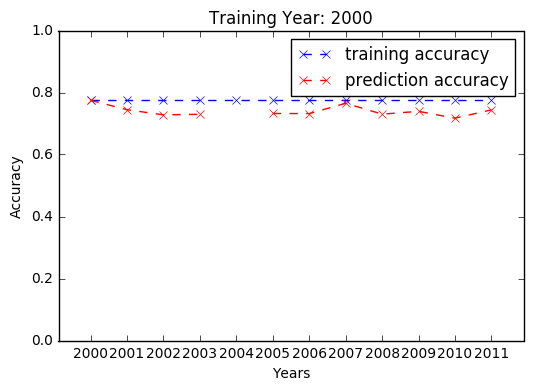

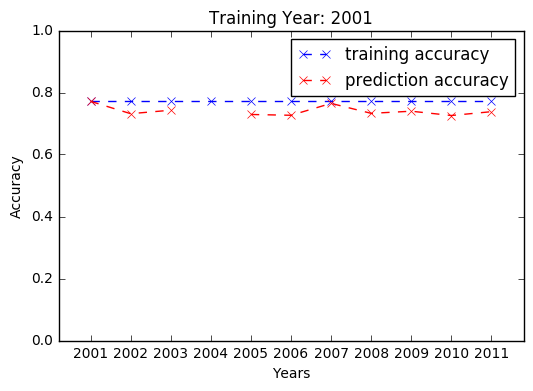

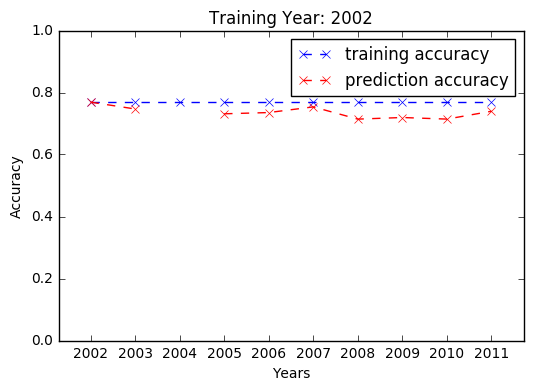

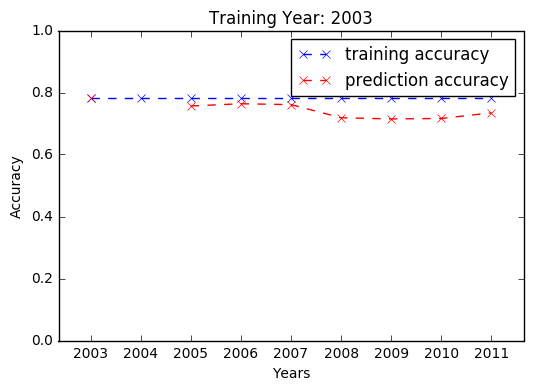

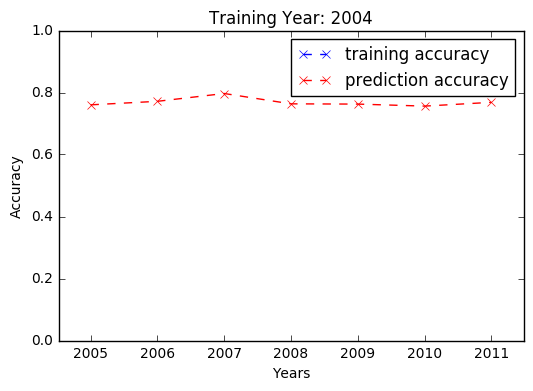

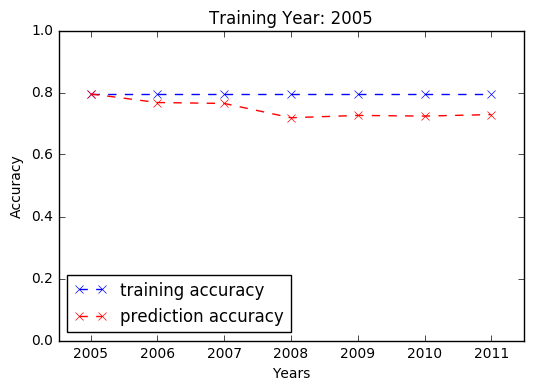

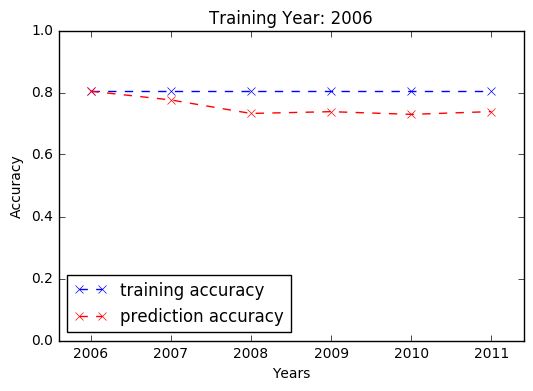

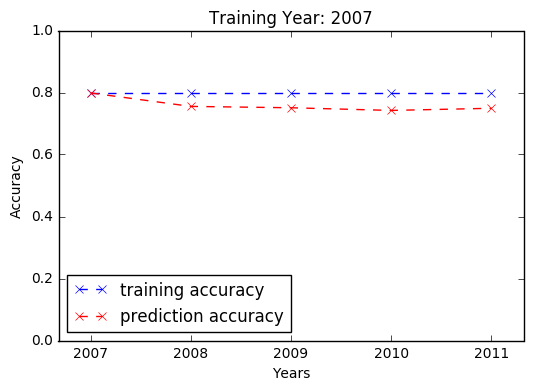

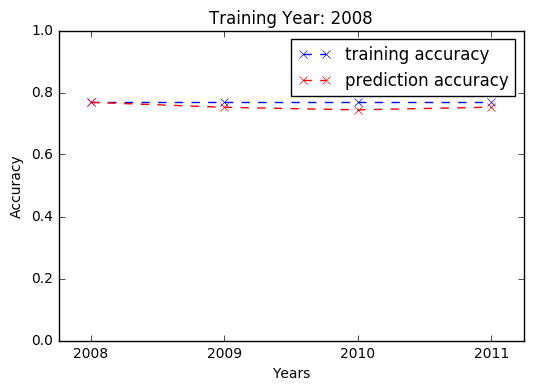

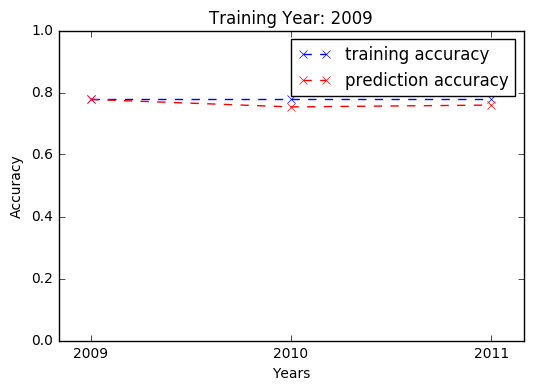

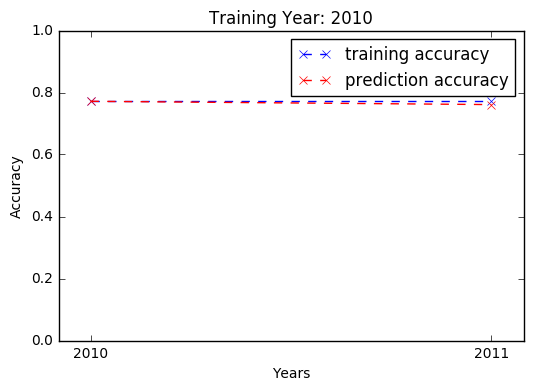

In [43]:
plotAllYears(Adj_years,accu_map_all)